In [6]:
import sympy
import numpy as np

from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Reaction:
    reactants: List[Tuple[int, int]]  # (species_index, stoichiometry)
    products: List[Tuple[int, int]]   # (species_index, stoichiometry)

        
def generate_stoichiometry_matrix(L, n_reactions, reac_order=1, seed=None):
    """
    Generate a stoichiometry matrix A given a matrix L (whose nullspace defines conservation laws),
    the number of reactions, and the maximum reaction order.
    
    Args:
        L: sympy.Matrix, the matrix whose nullspace defines conservation laws
        n_reac: int, number of reactions (columns in A)
        reac_order: int, maximum allowed absolute value for stoichiometric coefficients (default 1)
        seed: int or None, random seed for reproducibility
        
    Returns:
        A: sympy.Matrix, the generated stoichiometry matrix
    """
    if seed is not None:
        np.random.seed(seed)
    nullspace = L.nullspace()
    n_null = len(nullspace)
    cols = []
    for m in range(n_reactions):
        while True:
            coefs = [np.random.randint(-2, 2) for _ in range(n_null)]  # -1, 0, or 1
            zero_col = sympy.zeros(*nullspace[0].shape)
            col = sum((c * v for c, v in zip(coefs, nullspace)), zero_col)
            sum_neg = sum(-x for x in col if x < 0)
            sum_pos = sum(x for x in col if x > 0)
            if (
                all(abs(x) <= reac_order for x in col)
                and sum_neg <= reac_order
                and sum_pos <= reac_order
                and sum_neg != 0
                and sum_pos != 0
                and not any(col == existing for existing in cols)
            ):
                break
        cols.append(col)
    A = sympy.Matrix.hstack(*cols)
    return A

def build_mass_action_odes(A, Reaction, species_prefix='S', rate_prefix='k'):
    """
    Given a stoichiometry matrix A and a Reaction class, build the mass action ODEs.
    Returns:
        S: tuple of sympy symbols for species concentrations
        k: tuple of sympy symbols for rate constants
        odes: list of sympy expressions for the ODEs
        reaction_network: list of Reaction objects
        rate_exprs: list of sympy expressions for reaction rates
    """
    n_species = A.shape[0]
    n_reactions = A.shape[1]

    # Build reaction network
    reaction_network = []
    for j in range(n_reactions):
        reactants = []
        products = []
        for i in range(n_species):
            stoich = A[i, j]
            if stoich < 0:
                reactants.append((i, -stoich))
            elif stoich > 0:
                products.append((i, stoich))
        reaction_network.append(Reaction(reactants, products))

    # Define symbols
    S = sympy.symbols(f'{species_prefix}1:{n_species+1}')
    k = sympy.symbols(f'{rate_prefix}1:{n_reactions+1}')

    # Build rate expressions
    rate_exprs = []
    for j, rxn in enumerate(reaction_network):
        rate = k[j]
        for idx, stoich in rxn.reactants:
            rate *= S[idx]**stoich
        rate_exprs.append(rate)

    # Build ODEs
    odes = [0 for _ in range(n_species)]
    for j, rxn in enumerate(reaction_network):
        rate = rate_exprs[j]
        for idx, stoich in rxn.reactants:
            odes[idx] -= stoich * rate
        for idx, stoich in rxn.products:
            odes[idx] += stoich * rate

    return S, k, odes, reaction_network, rate_exprs

    # Print the parsed reaction network
def print_reaction_network(reaction_network):
    for idx, rxn in enumerate(reaction_network):
        react_str = ' + '.join([f"S{r[0]+1}{'('+str(r[1])+')' if r[1]>1 else ''}" for r in rxn.reactants]) or '∅'
        prod_str = ' + '.join([f"S{p[0]+1}{'('+str(p[1])+')' if p[1]>1 else ''}" for p in rxn.products]) or '∅'
        print(f"R{idx+1}: {react_str} -> {prod_str}")

In [12]:
L = sympy.Matrix([
    [1, 2, 0, 1, 0],
    [0, 0, 1, 0, 1]
])

L = sympy.Matrix([
    [1, 0, 0, 1, 1, 0],
    [0, 1, 0, 0, 1, 1],
    [0, 0, 1, 1, 0, 1],
])

L = sympy.Matrix([
    [1, 1, 1, 1, 1, 1],
])


n_reactions = 12
n_species = L.shape[1]

### check that there are no accidental conservation laws
reac_order = 1

A = generate_stoichiometry_matrix(L, n_reactions, reac_order=1, seed=3)
sympy.pprint(A)

S, k, odes, reaction_network, rate_exprs = build_mass_action_odes(A, Reaction)
print_reaction_network(reaction_network)

⎡1   1   0   1   0   0   0   -1  -1  0   0   0 ⎤
⎢                                              ⎥
⎢0   0   0   0   0   0   0   0   0   0   1   -1⎥
⎢                                              ⎥
⎢-1  0   -1  0   0   0   0   1   0   -1  -1  0 ⎥
⎢                                              ⎥
⎢0   0   0   0   -1  -1  0   0   0   0   0   1 ⎥
⎢                                              ⎥
⎢0   -1  0   0   0   1   -1  0   0   1   0   0 ⎥
⎢                                              ⎥
⎣0   0   1   -1  1   0   1   0   1   0   0   0 ⎦
R1: S3 -> S1
R2: S5 -> S1
R3: S3 -> S6
R4: S6 -> S1
R5: S4 -> S6
R6: S4 -> S5
R7: S5 -> S6
R8: S1 -> S3
R9: S1 -> S6
R10: S3 -> S5
R11: S3 -> S2
R12: S2 -> S4


In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Suppose S = (S1, S2, ..., S5), k = (k1, ..., k7)
# odes is a list of sympy expressions in S and k

# Create a function for the right-hand side
ode_func = sympy.lambdify((S, k), odes, modules='numpy')

def rhs(t, y, k_values):
    # y: concentrations at time t
    # k_values: array of rate constants
    return np.array(ode_func(y, k_values)).flatten()


# Example initial concentrations and rate constants
#y0 = [1.0, 0.5, 0.2, 1.0, 0.2, 0.5]  # adjust as needed

y0 = 2 * np.random.rand(n_species)
print(y0)
k_values = 5 * np.random.rand(n_reactions)
t_span = (0, 50)                 # time interval
dt = 0.001
t_eval = np.linspace(*t_span, int(t_span[1]/dt))  # evaluate at 1000 points (dt = 0.2)

[0.8020023  0.6407063  1.46702165 1.75032645 1.19623335 1.01710495]


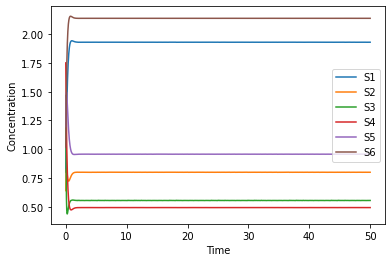

In [14]:
sol = solve_ivp(rhs, t_span, y0, args=(k_values,), t_eval=t_eval)


for i in range(n_species):
    plt.plot(sol.t, sol.y[i], label=f'S{i+1}')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

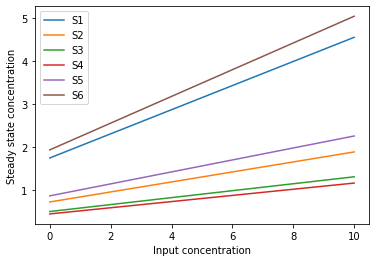

In [16]:
t_span = (0, 500)                 # time interval
dt = 0.01
t_eval = np.linspace(*t_span, int(t_span[1]/dt))  # evaluate at 1000 points (dt = 0.2)

#k_values = 5 * np.random.rand(n_reactions)

input_type = 'concentration'
input_idx = 1
dv = 0.1
crange = 10
input_vals =  np.linspace(0, crange, int(crange/dv))

# input_type = 'rate'
# input_idx = 1
# input_vals =  np.linspace(-10, 10, 41)

def compute_ss_response_as_function_of_input(rhs, k_values, y0, t_eval, input_type, input_idx, input_vals):
    ss_response = []
    for input_val in input_vals:
        if input_type == 'rate':
            k_values_copy = k_values.copy()
            k_values_copy[input_idx] = k_values_copy[input_idx] * np.exp(input_val)
            sol = solve_ivp(rhs, t_span, y0, args=(k_values_copy,), t_eval=t_eval, method='LSODA', rtol=1e-5, atol=1e-6)
        elif input_type == 'concentration':
            y0_copy = y0.copy()
            y0_copy[input_idx] = input_val
            sol = solve_ivp(rhs, t_span, y0_copy, args=(k_values,), t_eval=t_eval, method='LSODA', rtol=1e-3, atol=1e-6)
        ss_response.append(sol.y[:, -1])
    return np.array(ss_response)


ss_response = compute_ss_response_as_function_of_input(rhs, k_values, y0, t_eval, input_type, input_idx, input_vals)

for i in range(ss_response.shape[1]):
    plt.plot(input_vals, ss_response[:, i], label=f'S{i+1}')
plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration') 
plt.legend()



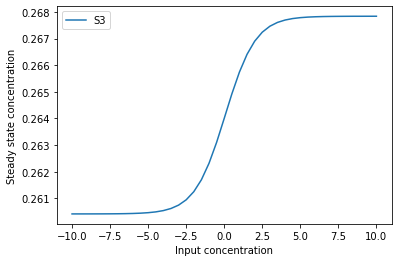

In [250]:
plt.plot(input_vals, ss_response[:, 5], label=f'S{2+1}')
plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration') 
plt.legend()

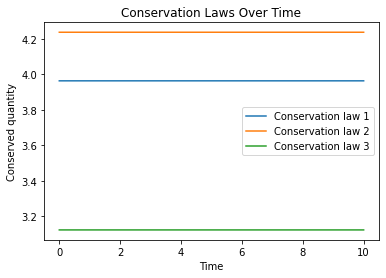

In [46]:
# If L is a sympy Matrix, convert to numpy
L_np = np.array(L).astype(float)  # shape: (n_laws, n_species)
S_sol = sol.y                     # shape: (n_species, n_timepoints)

# Compute conserved quantities at each timepoint
Q = L_np @ S_sol  # shape: (n_laws, n_timepoints)

# Plot each conserved quantity over time
for i in range(Q.shape[0]):
    plt.plot(sol.t, Q[i], label=f'Conservation law {i+1}')
plt.xlabel('Time')
plt.ylabel('Conserved quantity')
plt.legend()
plt.title('Conservation Laws Over Time')
plt.show()